# Import Libs

In [1]:
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F

import os
import numpy as np
from glob import glob
import glob
import random
import imageio
from torchvision import transforms
from collections import defaultdict

import segmentation_models_pytorch as smp

# Import Dataset
- Import folder with images
- Import folder with masks
- Create list with training and testing data

In [2]:
# get all the image and mask path and number of images
folder_data_train = glob.glob("train/samples/*tiff")
folder_mask_train = glob.glob("train/labels/*tiff")

folder_data_val = glob.glob("val/samples/*tiff")
folder_mask_val = glob.glob("val/labels/*tiff")

folder_data_test = glob.glob("test/samples/*tiff")
folder_mask_test = glob.glob("test/labels/*tiff")

train_image_paths = folder_data_train[:]
val_image_paths = folder_data_val[:]
test_image_paths = folder_data_test[:]

train_mask_paths = folder_mask_train[:]
val_mask_paths = folder_mask_val[:]
test_mask_paths = folder_mask_test[:]

# Custom Dataset

In [3]:
class CustomDataset(data.Dataset):
    def __init__(self, image_paths, target_paths, transform=None, transform_label=None):

        self.image_paths = image_paths
        self.target_paths = target_paths
        self.transform = transform
        self.transform_label = transform_label
        
    def __getitem__(self, index):

        image = imageio.imread(self.image_paths[index])
        image = np.asarray(image, dtype='float32')
        
        mask = imageio.imread(self.target_paths[index])
        mask = np.asarray(mask, dtype='int64')
        mask = np.where(mask==2, 0, mask) # some images has soil annotations as well
        
        seed = np.random.randint(2147483647)
        random.seed(seed)
        torch.manual_seed(seed)
        
        if self.transform is not None:
            image = self.transform(image)
            
        random.seed(seed)
        torch.manual_seed(seed)
        if self.transform_label is not None:
            mask = self.transform(mask)
            mask = mask.squeeze(0)
        
        return image, mask

    def __len__(self):

        return len(self.image_paths)
    
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomVerticalFlip()])


train_dataset = CustomDataset(train_image_paths, train_mask_paths, transform=transform, transform_label=transform)
val_dataset = CustomDataset(val_image_paths, val_mask_paths, transform=transforms.ToTensor(), transform_label=None)
test_dataset = CustomDataset(test_image_paths, test_mask_paths, transform=transforms.ToTensor(), transform_label=None)

In [4]:
image_datasets = {
    'train': train_dataset, 'val': val_dataset, 'test': test_dataset
}

dataloaders = {
    'train': torch.utils.data.DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=0),
    'val': torch.utils.data.DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=0),
    'test': torch.utils.data.DataLoader(test_dataset, batch_size=2, shuffle=False, num_workers=0)
}

# Import Model

In [5]:
ENCODER = 'efficientnet-b7'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['solar_panel']
ACTIVATION = 'sigmoid'
DEVICE = 'cuda'

model = smp.Unet(
    in_channels = 4,
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

# Loss & Optimizer

In [8]:
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5) #, ignore_channels=[False, True, False, False]),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.001),
])

In [9]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [10]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size=21, shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=21, shuffle=False, num_workers=0)

In [ ]:
max_score = 0
for i in range(0, 100):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './datasets/solar_panel/models/vgg16.pth')
        print('Model saved!')
    
    if i==40:
        optimizer.param_groups[0]['lr'] = 1e-3
        print('Decrease decoder learning rate to 1e-3!')
        
    if i == 80:
        optimizer.param_groups[0]['lr'] = 1e-4
        print('Decrease decoder learning rate to 1e-4!')

# LOAD MODEL

In [11]:
model = torch.load('datasets/solar_panel/models/effb7.pth')
#model = torch.load('datasets/solar_panel/models/effb4.pth')
#model = torch.load('datasets/solar_panel/models/effb0.pth')
#model = torch.load('datasets/solar_panel/models/x101.pth')
#model = torch.load('datasets/solar_panel/models/r101.pth')
#model = torch.load('datasets/solar_panel/models/vgg16.pth')

# EVAL MODEL

In [12]:
import math
with torch.no_grad():
    model.eval()

    inp, lab = next(iter(test_loader))

    inp = inp.to(DEVICE)
    lab = lab.to(DEVICE)

    # Predict
    pred = model(inp)

# Accuracy, IoU, and F-score

In [13]:
lbl = lab.cpu().numpy().reshape(-1)
target = pred.data.cpu().numpy().reshape(-1)
from sklearn.metrics import average_precision_score, roc_auc_score, f1_score, jaccard_score, accuracy_score
def compute_metrics(label, target):
    acc_50 = accuracy_score(label, np.where(target>0.5, 1, 0))
    acc_75 = accuracy_score(label, np.where(target>0.75, 1, 0))
    
    iou_50 = jaccard_score(label, np.where(target>0.5, 1, 0))
    iou_75 = jaccard_score(label, np.where(target>0.75, 1, 0))
    
    f_50 = f1_score(label, np.where(target>0.5,1,0))
    f_75 = f1_score(label, np.where(target>0.75,1,0))
    
    print('Accuracy', round(acc_50*100, 2), '| ', round(acc_75*100, 2))
    print('IoU', round(iou_50*100, 2), '| ', round(iou_75*100,2))
    print('F-score', round(f_50*100, 2), '| ', round(f_75*100, 2))
    
compute_metrics(lbl, target)

Accuracy 97.94 |  97.9
IoU 88.8 |  88.51
F-score 94.07 |  93.91


# SHOW PREDICTIONS

torch.Size([224, 224])


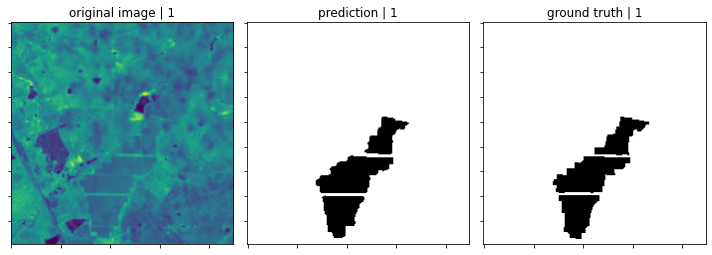

torch.Size([224, 224])


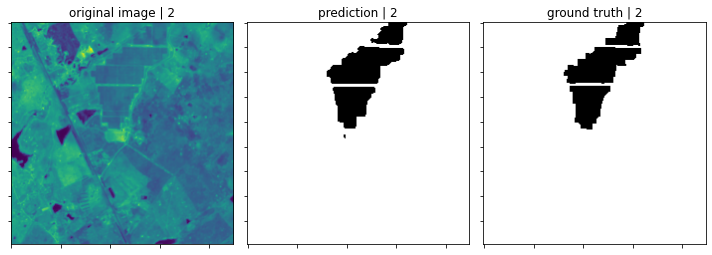

torch.Size([224, 224])


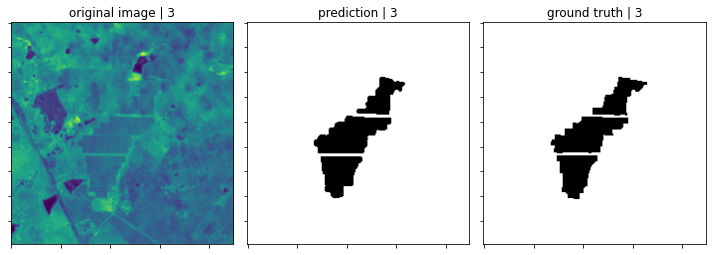

torch.Size([224, 224])


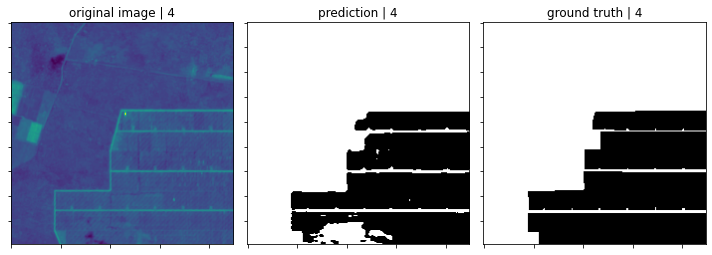

torch.Size([224, 224])


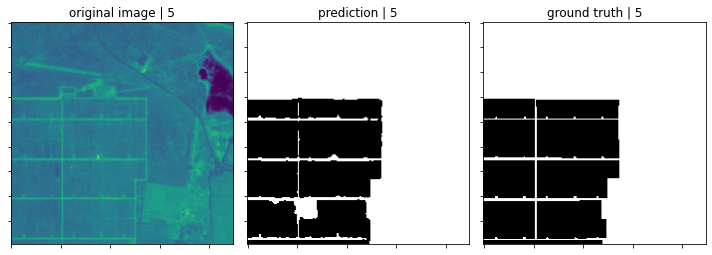

torch.Size([224, 224])


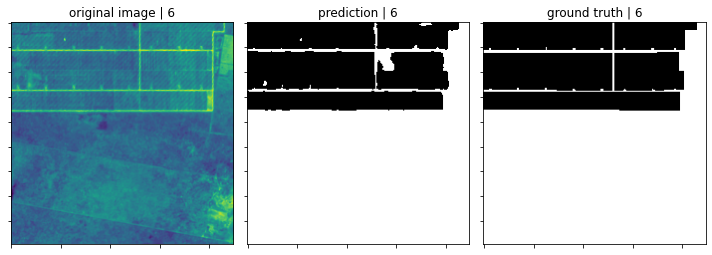

torch.Size([224, 224])


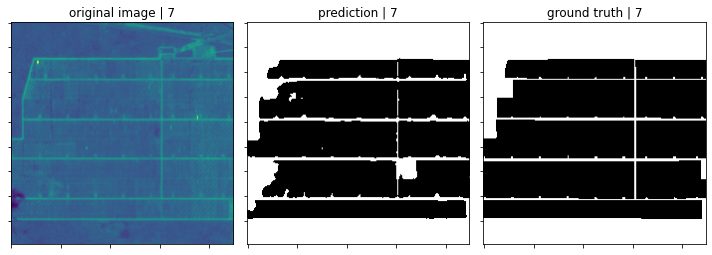

torch.Size([224, 224])


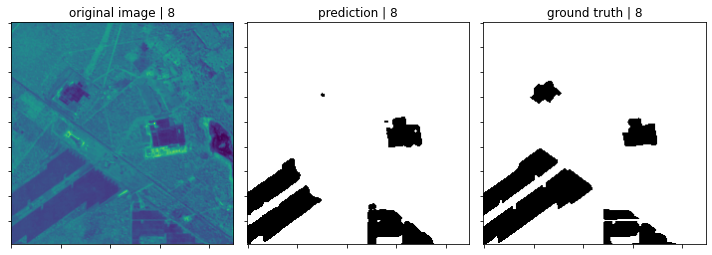

torch.Size([224, 224])


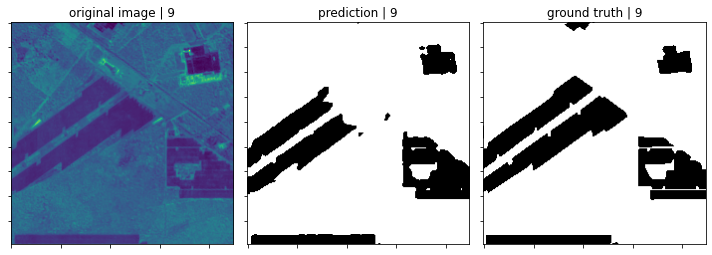

torch.Size([224, 224])


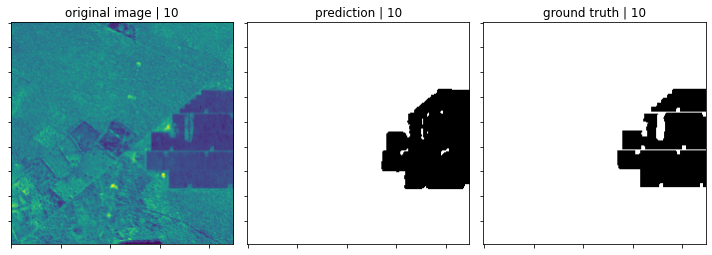

torch.Size([224, 224])


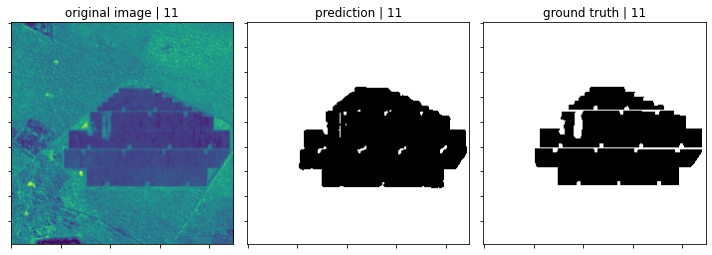

torch.Size([224, 224])


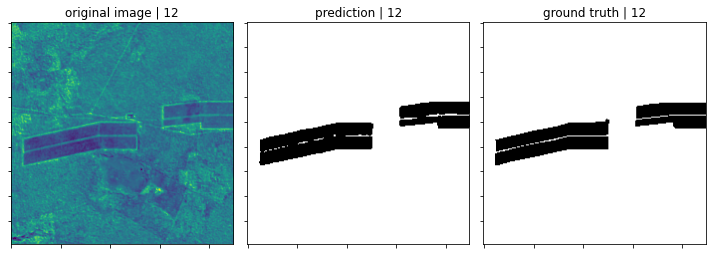

torch.Size([224, 224])


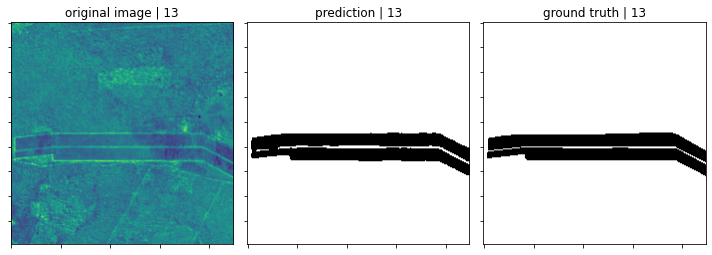

torch.Size([224, 224])


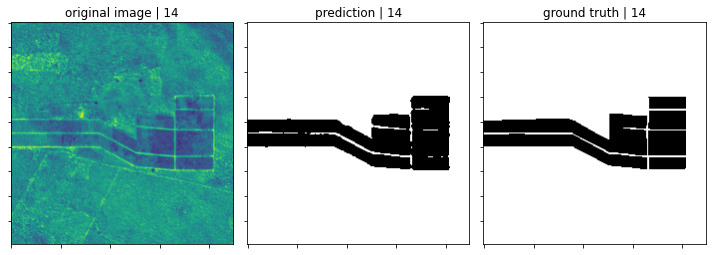

torch.Size([224, 224])


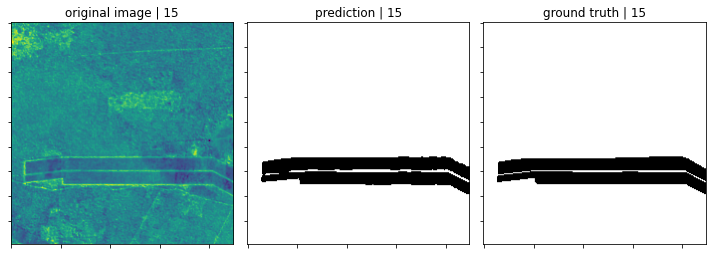

torch.Size([224, 224])


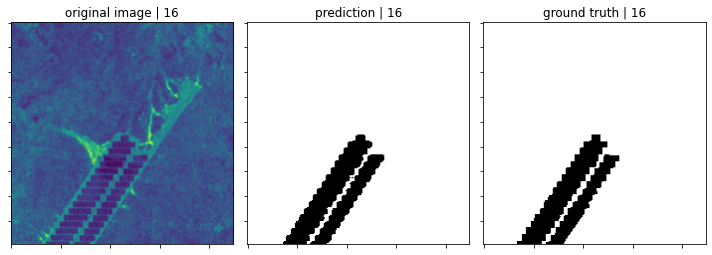

torch.Size([224, 224])


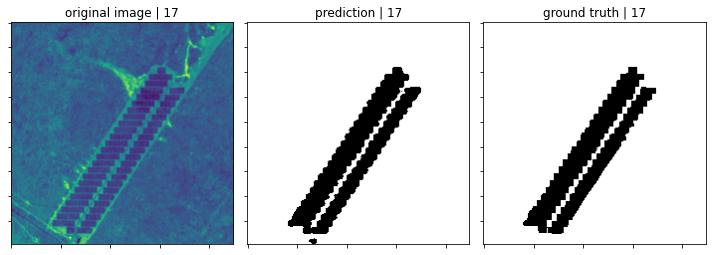

torch.Size([224, 224])


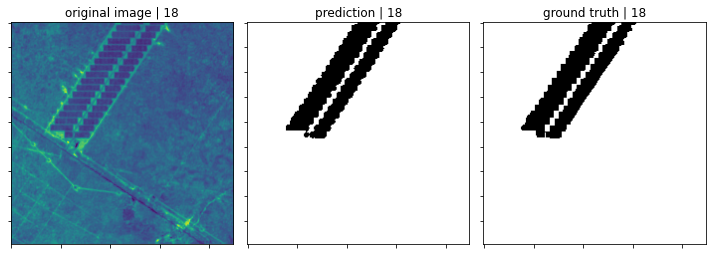

torch.Size([224, 224])


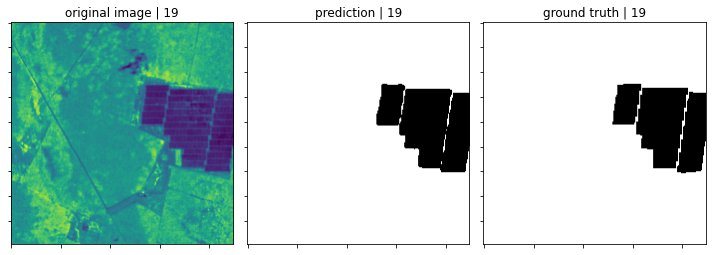

torch.Size([224, 224])


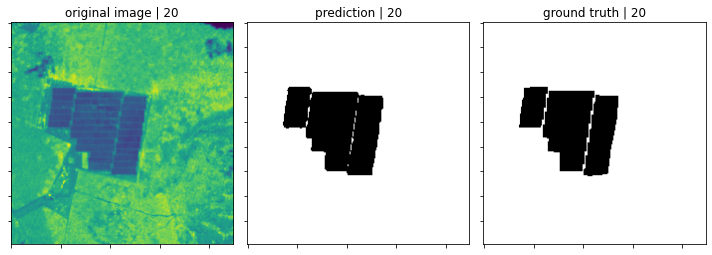

torch.Size([224, 224])


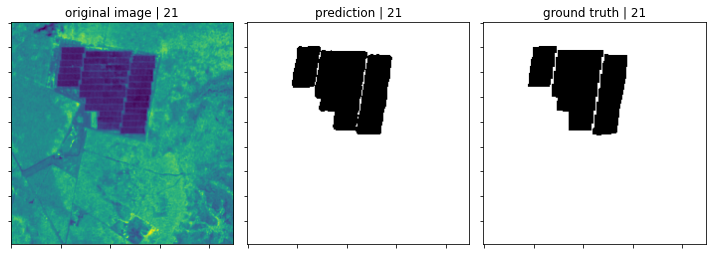

In [42]:
import matplotlib.pyplot as plt
for i in range(21):
    pred_img = pred[i].data.cpu().numpy().reshape(224,224)
    pred_img = np.where(pred_img>0.2, 1, 0)
    lab_unit = lab[i].cpu()
    inp_unit = inp[i].cpu() #.reshape(224,224)
    inp_unit = inp_unit[3,:,:].reshape(224,224)
    
    print(inp_unit.shape)
    
    NUM_ROWS = 1
    IMGs_IN_ROW = 3
    f, ax = plt.subplots(NUM_ROWS, IMGs_IN_ROW, figsize=(10,10))
    
    ax[0].imshow(inp_unit)
    ax[1].imshow(pred_img, cmap='binary')
    ax[2].imshow(lab_unit, cmap='binary')

    ax[0].set_title('original image | '+str(i+1))
    ax[1].set_title('prediction | '+str(i+1))
    ax[2].set_title('ground truth | '+str(i+1))
    
    ax[0].set_yticklabels([])
    ax[0].set_xticklabels([])
    
    ax[1].set_yticklabels([])
    ax[1].set_xticklabels([])
    
    ax[2].set_yticklabels([])
    ax[2].set_xticklabels([])

    plt.tight_layout()
    plt.show()

# MOSAICKING

In [15]:
from sklearn.metrics import roc_auc_score, average_precision_score
img_path = 'F:/PT Semantic Segmentation/datasets/solar_panel/scene_mosaic/img_scene.tif'
lbl_path = 'F:/PT Semantic Segmentation/datasets/solar_panel/scene_mosaic/mask.tif'

def mosaicking(img_path, stride, window, model):
    image = imageio.imread(img_path).astype('float32') # Ler imagem
    image = image[:,:,:1568]
    image = image.reshape(1, 4, 672, 1568) # formato (1, C, H, W)

    print(image.shape)
    image = torch.from_numpy(image) # passar para tensor para ler a imagem
    #print(image.shape) # (1, C, H, W)
    
    width = image.shape[2]
    height = image.shape[3]

    new_height = int((height-window)/stride)*stride 
    new_width = int((width-window)/stride)*stride

    img_width = new_width+window
    img_height = new_height+window

    img_final = np.zeros((672, 1568), dtype="float32")
    contador_final = np.zeros((672, 1568), dtype='float32')
    #classified_image = np.zeros((512,512))
    
    model.eval()
    
    for row in range(0,new_width+1, stride):
        for col in range(0,new_height+1, stride):

            actual_img = image[:, :, row:row+window, col:col+window].to(DEVICE).float()
            actual_pred = model(actual_img)
            actual_pred = actual_pred.data.cpu().numpy()
            actual_pred = actual_pred.reshape(window,window)

            for pjlin in range(0, window):
                p1 = row + pjlin
                for pjcol in range(0, window):
                    p2 = col + pjcol   
                    value = actual_pred[pjlin, pjcol]
                    img_final[p1,p2] += value
                    contador_final[p1,p2] += 1
    
    classified_image = img_final/contador_final
    classified_image = np.nan_to_num(classified_image)
    return classified_image

def mosaick_metrics(clf_img, lbl_path):
    clf_img = np.nan_to_num(clf_img)
    clf_img = clf_img.reshape(-1)
    
    lbl = imageio.imread(lbl_path).astype('int16')
    lbl = np.where(lbl>1, 0, lbl)
    lbl = lbl.reshape(-1)

    roc = roc_auc_score(lbl, clf_img)
    pr = average_precision_score(lbl, clf_img)
    print('ROC:', round(roc*100,2), ' | PR:', round(pr*100, 2))

In [16]:
# Get classifications for different mosaicking strides
clf_7 = mosaicking(img_path, 7, 224, model)
clf_28 = mosaicking(img_path, 28, 224, model)
clf_112 = mosaicking(img_path, 112, 224, model)
clf_224 = mosaicking(img_path, 224, 224, model)

(1, 4, 672, 1568)
(1, 4, 672, 1568)
(1, 4, 672, 1568)
(1, 4, 672, 1568)


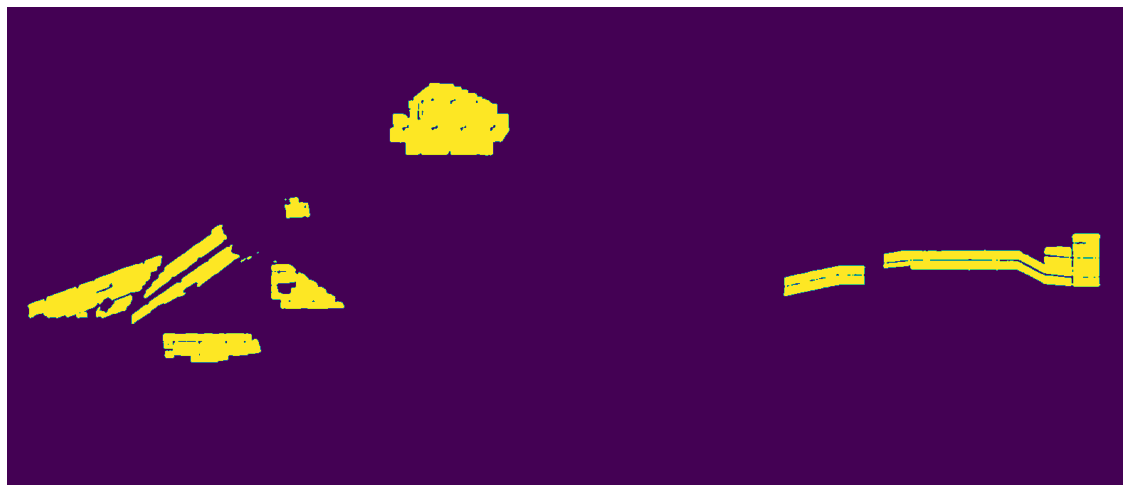

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
plt.imshow(np.where(clf_28>0.3,1,0))
plt.axis('off')
#plt.savefig('scene_s224.png', dpi=500, bbox_inches='tight', pad_inches=0)
plt.show()

In [20]:
def mosaick_metrics_l(clf_img, label):
    clf_img = clf_img.reshape(-1)
    label = label.reshape(-1)
    
    roc = roc_auc_score(label, clf_img)
    pr = average_precision_score(label, clf_img)
    print('ROC:', round(roc*100,2), ' | PR:', round(pr*100, 2))

In [21]:
lbl = imageio.imread(lbl_path).astype('int16')
lbl = lbl[:,:1568]

In [22]:
# AP Scores
print(100*round(average_precision_score(lbl.reshape(-1), clf_7.reshape(-1), pos_label=255),4))
print(100*round(average_precision_score(lbl.reshape(-1), clf_28.reshape(-1), pos_label=255),4))
print(100*round(average_precision_score(lbl.reshape(-1), clf_112.reshape(-1), pos_label=255),4))
print(100*round(average_precision_score(lbl.reshape(-1), clf_224.reshape(-1), pos_label=255),4))

96.19
95.22
94.75
93.31


In [23]:
# ROC AUC
print(100*round(roc_auc_score(lbl.reshape(-1), clf_7.reshape(-1)),4))
print(100*round(roc_auc_score(lbl.reshape(-1), clf_28.reshape(-1)),4))
print(100*round(roc_auc_score(lbl.reshape(-1), clf_112.reshape(-1)),4))
print(100*round(roc_auc_score(lbl.reshape(-1), clf_224.reshape(-1)),4))

99.31
98.74000000000001
98.24000000000001
97.03


In [24]:
disp_img = imageio.imread(img_path).astype('float32')
disp_img = np.transpose(disp_img, (1,2,0))
disp_img[:,:,0].max()

5905.0

In [25]:
disp_img[:,:,0] = disp_img[:,:,0]/5905
disp_img[:,:,1] = disp_img[:,:,1]/5145
disp_img[:,:,2] = disp_img[:,:,2]/6071
disp_img[:,:,3] = disp_img[:,:,3]/5758

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


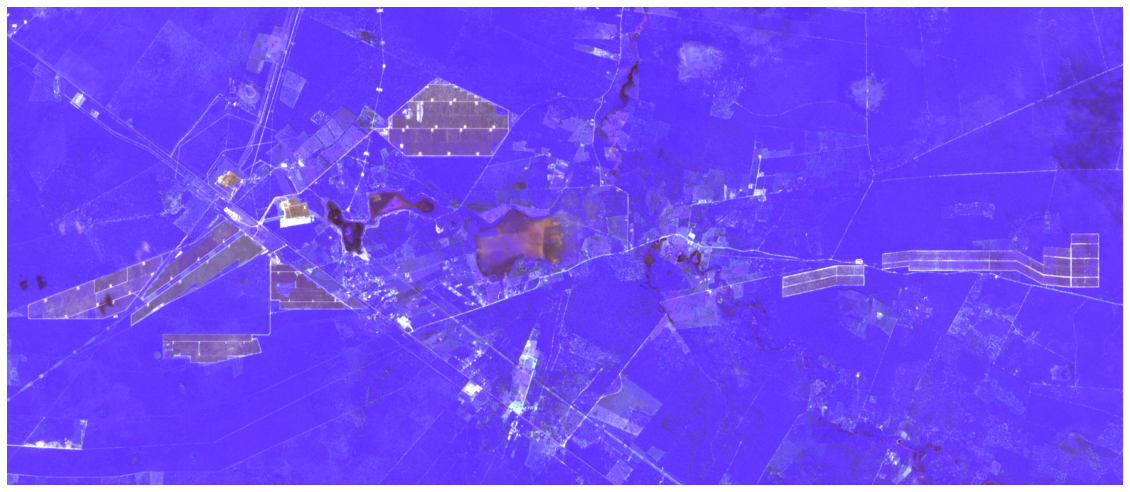

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,20))
plt.imshow(disp_img[:,:,1:4]*3)
plt.axis('off')
#plt.savefig('scene_im.png', dpi=500, bbox_inches='tight', pad_inches=0)
plt.show()

In [27]:
lbl = imageio.imread(lbl_path).astype('int16')
lbl = np.where(lbl>1, 0, lbl)

In [28]:
# SHOW IMAGES

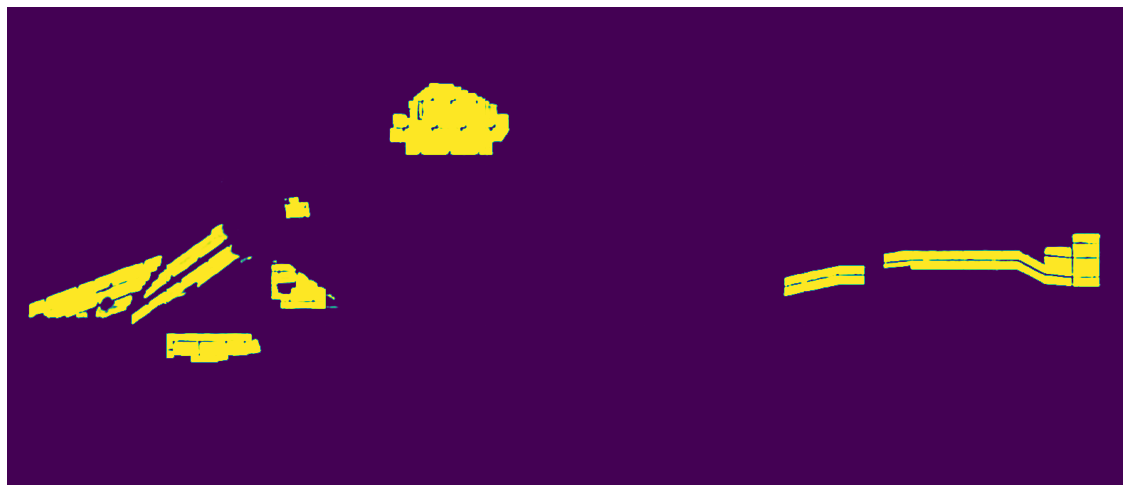

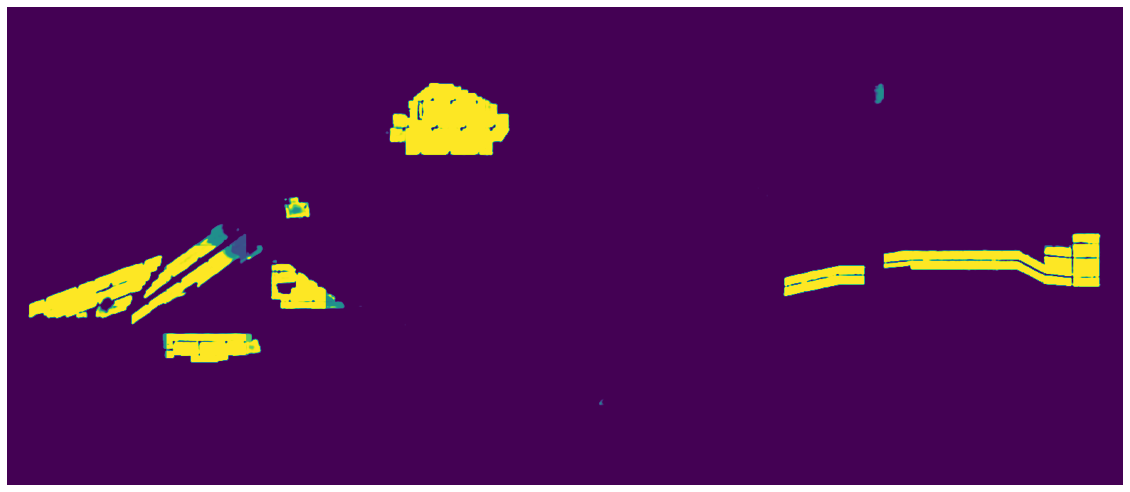

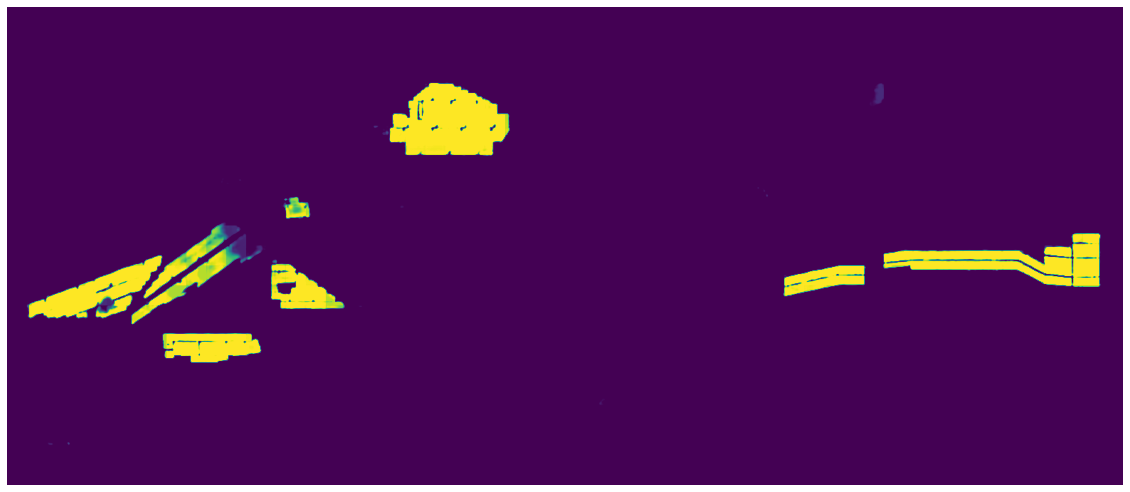

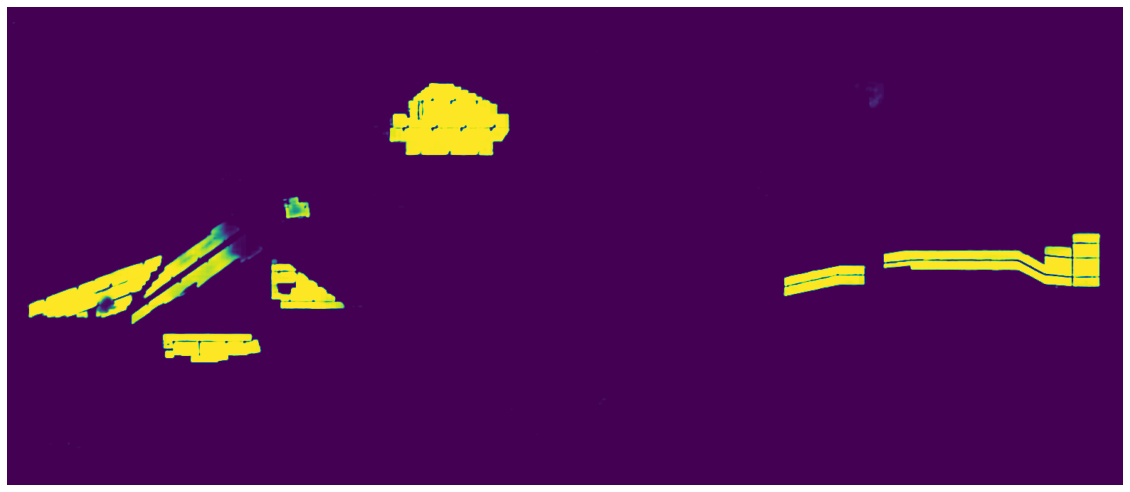

In [29]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
plt.imshow(clf_224)
plt.axis('off')
#plt.savefig('scene_s224.png', dpi=500, bbox_inches='tight', pad_inches=0)
plt.show()

plt.figure(figsize=(20,20))
plt.imshow(clf_112)
plt.axis('off')
#plt.savefig('scene_s224.png', dpi=500, bbox_inches='tight', pad_inches=0)
plt.show()

plt.figure(figsize=(20,20))
plt.imshow(clf_28)
plt.axis('off')
#plt.savefig('scene_s224.png', dpi=500, bbox_inches='tight', pad_inches=0)
plt.show()

plt.figure(figsize=(20,20))
plt.imshow(clf_7)
plt.axis('off')
#plt.savefig('scene_s224.png', dpi=500, bbox_inches='tight', pad_inches=0)
plt.show()

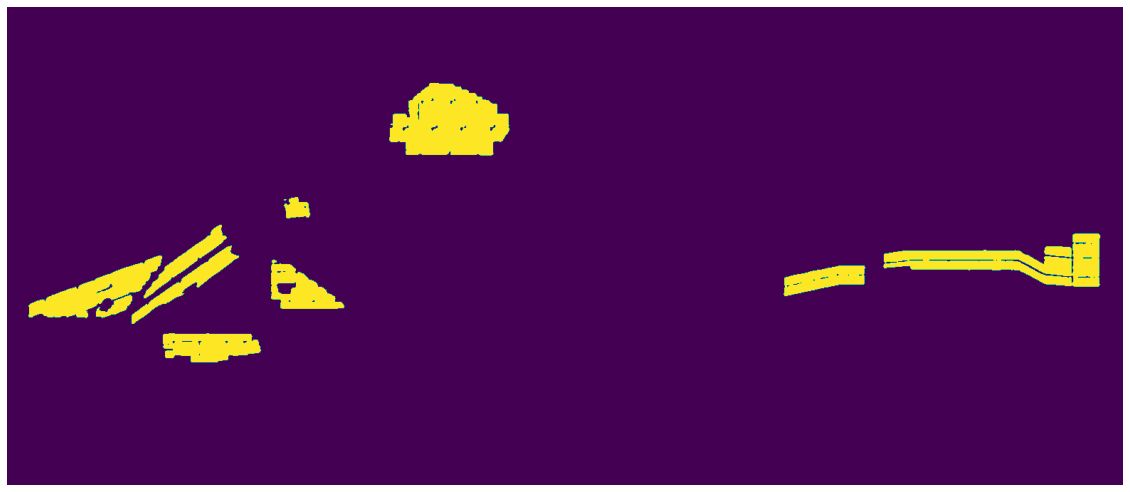

In [30]:
import matplotlib.pyplot as plt

# USING A THRESHOLD
plt.figure(figsize=(20,20))
plt.imshow(np.where(clf_7>0.3,1,0))
plt.axis('off')
#plt.savefig('full.png', dpi=500, bbox_inches='tight', pad_inches=0)
plt.show()